In [1]:
# # # Copyright (C) 2022  Syed Salman Habeeb Quadri
# # # https://github.com/SalmanHabeeb/Stroke-predictor/blob/main/License%20Notice.md

# Exploratory data analysis of Stroke for stroke prediction dataset

## Import required packages

In [1]:
# !pip3 install numpy==1.21.6
# !pip3 install pandas==1.3.5
# !pip3 install matplotlib==3.2.2
# !pip3 install scipy==1.4.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

## Define necessary functions.

In [3]:
def plot_pie_value_count(target_column, df, label_dict = None, autopct = '%1.1f%%', title = 'Chart', title_fontweight = 'bold', 
                         title_fontstyle = 'italic', title_fontsize  = 14):
    labels = []
    if isinstance(label_dict, dict):
        for i in range(df[target_column].value_counts().shape[0]):
            labels.append(label_dict[df[target_column].value_counts().index[i]])
    elif label_dict is None:
        labels = df[target_column].value_counts().index
    else:
        raise NotImplementedError('Pass a Dictionary or None')
    plt.pie(df[target_column].value_counts(), labels = labels, autopct = autopct)
    plt.title(title, fontsize = title_fontsize, fontweight = title_fontweight, fontstyle = title_fontstyle)
    plt.show()

In [4]:
def compute_normal_confidence_interval(value, target_column, chance_column, df, level_of_significance, tails = 2, compare = None):
    '''
        Input:- value                 : unique value denoting an event which needs to be correlated with that of event in chance_column
                target_column         : (string type) The name of column which contains the event which needs to be correlated with that of 
                                        event in chance_column
                chance_column         : (string type) Name of Pandas DataFrame column containing the boolean values for the occurance of event.
                                        The mean of the column gives the chance of the event.
                df                    : Pandas DataFrame, contains both target_column and chance_column
                level_of_significance : (float type) The level of significance at which the normal confidence interval is computed.
                tails                 : (int type) Signigfies whether the confidence interval is one-sided (e.g., (-inf, 1)) or two-sided
                                        (e.g., (2, 5))
                compare               : (string type) If the interval is one-sided(i.e., tails = 1) then this parameter specifies whether it is
                                         hand side or left hand side.

        The function takes a unique value belonging to target_column, computes the chance of occurance of boolean event from chance_column,
        and returns the normal confidence interval with given level of significance and given no. of tails for distribution.
        Here, the assumption is that the distribution of sample mean is normal, i.e., either the underlying distribution of chance_column
        is normal, or the number of elements inside chance column are normal.

        Displays the confidence intervals computed, and also whether the chance of occurance of second event given the first event has occured
        lies within the confidence interval.
    '''
    
    if isinstance(value, list) | isinstance(value, tuple):
        mask = (df[target_column] < value[1]) & (df[target_column] > value[0])
    else:
        mask = (df[target_column] == value)
        
    sample_variance_of_difference = np.sqrt((df[chance_column].var()/len(df[chance_column])) + \
    (df[mask][chance_column].var()/len(df[mask][chance_column])))
    if tails == 2:
        alphaby2 = 1 - (level_of_significance/2)
        z = st.norm.ppf(alphaby2)
        confidence_interval = (
            df[chance_column].mean() - (z*sample_variance_of_difference),
            df[chance_column].mean() + (z*sample_variance_of_difference),
            )
    else:
        alpha = 1 - level_of_significance
        z = st.norm.ppf(alpha)
        
        if compare == 'lt':
            confidence_interval = (
                -np.inf,
                df[chance_column].mean() + (z*sample_variance_of_difference),
             )
        else:
            confidence_interval = (
                df[chance_column].mean() - (z*sample_variance_of_difference),
                np.inf
             )
    if isinstance(value, list) | isinstance(value, tuple):
        representation = f"range {value}"
    else:
        representation = f"value {value}"
    if (df[mask][chance_column].mean() < confidence_interval[1]) & \
        (df[mask][chance_column].mean() > confidence_interval[0]):
        print(f'Sample mean of {chance_column} for {representation} in {target_column} column is {df[mask][chance_column].mean():.2f} \
and lies within confidence interval ({confidence_interval[0]:.2f},{confidence_interval[1]:.2f})')
        
    else:
        print(f'Sample mean of {chance_column} for {representation} in {target_column} column is {df[mask][chance_column].mean():.2f} \
and lies outside of confidence interval ({confidence_interval[0]:.2f},{confidence_interval[1]:.2f})')

In [5]:
def plot_chances(
    target_column,
    chance_column,
    df,
    labels = None,
    x_tick_labels = None,
    figsize  = (12, 8),
    x_label = 'X',
    y_label = 'Y',
    title = 'Title',
    title_fontweight = 'bold',
    title_fontstyle = 'italic',
    title_fontsize = 15,
    ):
    '''
        Input:- target_column    : (string type) Name of column whose events are to be plotted on x-axis
                chance_column    : (string type) Name of column which denotes occurance of single event using 0 and 1. Conditional 
                                   probability of this column is to plotted.
                df               : (Pandas DataFrame type) Dataframe which contains target_column and chance_column as columns
                labels           : (tuple or None type) This contain the arguments for range object. This is provided to give labels
                                   in case of continuous numerical data in target_column.
                x_tick_labels    : (dict or None type) It is a dictionary mapping unique values of target_column with custom labels we
                                   want as x-tick labels
                figsize          : (tuple of int) It contains the size of figure we want for the plot
                x_label          : (string type) Denotes label for x-axis
                y_label          : (string type) Denotes label for y-axis
                title            : (string type) Denotes the title of plot
                title_fontweight : (string type) Used to set the fontweight argument of plt.title()
                title_fontstyle  : (string type) Used to set the fontstyle argument of plt.title()
                title_fontsize   : (string type) Used to set the fontsize argument of plt.title()

        Computes the coonditional probability of occurance of event represented in chance_column, given that a unique event from 
        target_column took place.

        Displays matplotlib bar plots of the computed probability. The probability is plotted along y-axis while the events from 
        target_column are along x_axis.
    '''
    if labels is None:
        labels = list(df[target_column].unique())
    if x_tick_labels is None:
        x_tick_labels = labels
    fig, ax = plt.subplots(figsize = figsize, )
    if isinstance(labels, tuple):
        start = labels[0]
        end = labels[1]
        step = labels[2]
        start_labels = np.arange(start, end, step)
        for i in np.arange(len(start_labels)):
            plt.bar(i, df[(df[target_column] > start_labels[i]) & (df[target_column] < (start_labels[i] + step))][chance_column].mean())
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xticks(np.arange(len(start_labels)))
        x_tick_labels = [f'{i}-{i+step}' for i in start_labels]
        ax.set_xticklabels(x_tick_labels)
    else:
        for i in np.arange(len(labels)):
            plt.bar(i, df[df[target_column] == labels[i]][chance_column].mean())
        
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xticks(np.arange(len(labels)))
        if isinstance(x_tick_labels, dict):
            x_tick_labels_list = [i for i in np.arange(len(labels))]
            for i in labels:
                x_tick_labels_list[labels.index(i)] = x_tick_labels[i]
            ax.set_xticklabels(x_tick_labels_list)
        else:
            ax.set_xticklabels(x_tick_labels)

    plt.title(title, fontweight = title_fontweight, fontstyle = title_fontstyle, fontsize = title_fontsize)
    plt.show()

## Read the dataset

In [6]:
content = "https://raw.githubusercontent.com/SalmanHabeeb/Stroke-predictor/main/dataset/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(content)

## Let's explore the stroke prediction dataset

In [7]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [8]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [9]:
df = df.drop(columns = ['id'])

In [10]:
print(df['gender'].unique())
print(df['ever_married'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())
print(df['smoking_status'].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [11]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Representation of people in dataset

Let's check the statistics to know about the representation of age-groups, incidence of stroke in the given population, and other numerical parameters.

In [12]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


We see that median age of population is 45 years. Also, 25% of the population is aged below 25, another 25% is aged above 60 and remaining in between these ages. Thus, various age groups are adequately represented in the dataset.

Average glucose levels of the population is 106, well within the recommended limit 100 - 120 mg/dl. However, due to standard deviation, much of the population is outside of this limit. Only about 25% of population has normal level of diabetes. Nevertheless, this representation of non-diabetic people is sufficient for developing machine learning models.

It is clear that people with BMI < 33 are sufficiently represented. However, we are not sure about the representation of people with BMI > 33.

About 9.7% and 5.4% of population suffers from hypertension and heart disease respectively. Combined to this, percentage of people with stroke is only 4.7% against the background of 95.3% of population who never suffered from stroke. This can be difficult to handle for a machine learning model, since these classes are quite underrepresented when compared to their binary counterparts.

In [13]:
print('Percentage of population which has 35 < BMI < 45 : {:0.2f}%'.format(df[(df['bmi'] < 45) & (df['bmi'] > 35)].shape[0]*100/df.shape[0]))
print('Percentage of population which has 45 < BMI < 60 : {:0.2f}%'.format(df[(df['bmi'] < 60) & (df['bmi'] > 45)].shape[0]*100/df.shape[0]))

Percentage of population which has 35 < BMI < 45 : 14.64%
Percentage of population which has 45 < BMI < 60 : 2.78%


People with higher BMI (BMI > 45) are less represented. This can affect our machine learning models significantly.

Gender distribution of the population in our dataset

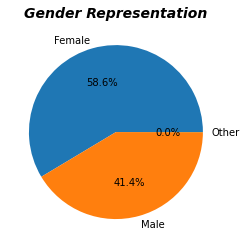

In [14]:
plot_pie_value_count('gender', df, title = 'Gender Representation')

Gender represenation of male and female classes is sufficient. However, non-binary population is not adequately represented.

Let's check the count of non-binary people.

In [15]:
df[df['gender'] == 'Other'].shape[0]

1

Only one member of non-binary class is on the dataset. Thus, we may conclude that no prediction can be made regarding non-binary people unless we get dataset which fairly represents them.

Let's plot the pie chart for distribution of married people in our dataset.

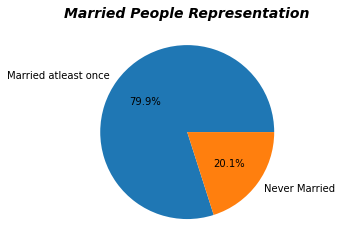

In [16]:
marriage_labels = {
    'Yes' : 'Married atleast once',
    'No'  : 'Never Married',
}
plot_pie_value_count('ever_married', df[df['age'] > 18], label_dict = marriage_labels, title = 'Married People Representation')

For adults (age > 18), there is sufficient representation of people who have married and those who never did.

Let's check if we have any data for children who are married.

In [17]:
df[(df['age'] < 18) & (df['ever_married'] == 'Yes')].shape[0]

0

So we have no data of children who are married. Nevertheless, child marriages are quite frequent in South Asian countries as well as in Middle-East and Africa. But, we may not be able to make any predictions regarding these class of people.

Let's check work-types adapted by people represented in our dataset

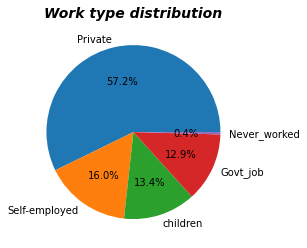

In [18]:
plot_pie_value_count('work_type', df, title = 'Work type distribution')

It is clear that those who have never worked are underrepresented. Thus, machine learning models may not perform well on this class

Checking the rural-urban divide in our dataset

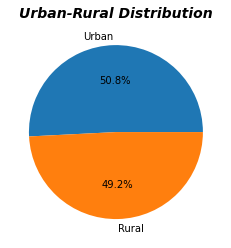

In [19]:
plot_pie_value_count('Residence_type', df, title = 'Urban-Rural Distribution')

Both urban and rural classes are equally represented.

Atlast, let's check the smoking patterns of the represented population.

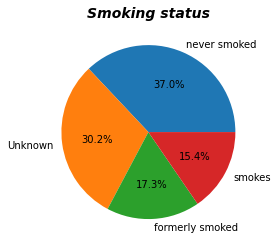

In [20]:
plot_pie_value_count('smoking_status', df, title = 'Smoking status')

It is clear that all classes are adequately represented. However, we don't have information about the smoking status of 30% of the population. This may bring down the performance of our models.

## Evaluating chances of getting stroke for different parameters

Let's check the chance of stroke for different genders.

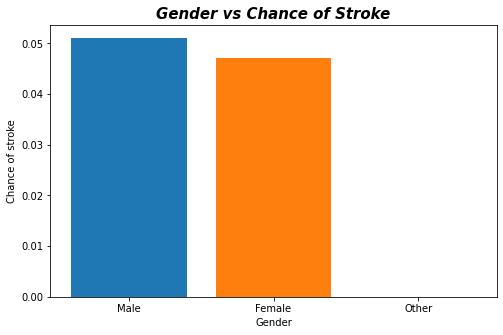

In [21]:
plot_chances('gender',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_label = 'Gender',
y_label = 'Chance of stroke',
title = 'Gender vs Chance of Stroke',
)

The chance of stroke look the same for male and female people. For others, the chance of stroke doesn't give any information because of lack of data.

We hypothesise that:

Null Hypothesis: H0:- chance of stroke is average for both males and females.

Alternate Hypothesis: H1:- chance of stroke is higher than average for males.

In [22]:
compute_normal_confidence_interval('Male', 'gender', 'stroke', df, 0.05)

Sample mean of stroke for value Male in gender column is 0.05 and lies within confidence interval (0.04,0.06)


Hence, we accept the null hypothesis that the chance of stroke is average for males as well as for females

Hypertension is known to be a significant factor in occurance of stroke. Let's plot the chances of occurance of stroke among people who have hypertension, and those who don't.

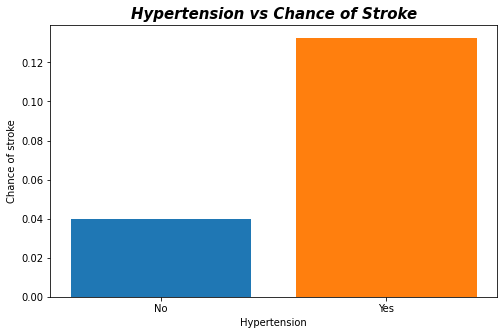

In [23]:
yesno = {
    1 : 'Yes',
    0 : 'No'
}
plot_chances('hypertension',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_tick_labels = yesno,
x_label = 'Hypertension',
y_label = 'Chance of stroke',
title = 'Hypertension vs Chance of Stroke',
)

Clearly, from plot the chance of stroke is high for people with hypertension. Hence, we hypothesise as follows:

Null hypothesis : H0 :- Stroke chance is above average for a person with hypertension

Alternate hypothesis H1 :- Stroke chance remains average for person with hypertension

In [24]:
compute_normal_confidence_interval(1, 'hypertension', 'stroke', df, 0.05, 1, 'gt')

Sample mean of stroke for value 1 in hypertension column is 0.13 and lies within confidence interval (0.02,inf)


Since the stroke chance for those with hypertension is significantly above average, we accept null hypothesis.

Hence, chance of stroke is high for people with hypertension

Heart disease are known to increase the risk of a person getting the stroke. Let's plot the chance of occurance of stroke among people who have heart disease against those who don't.

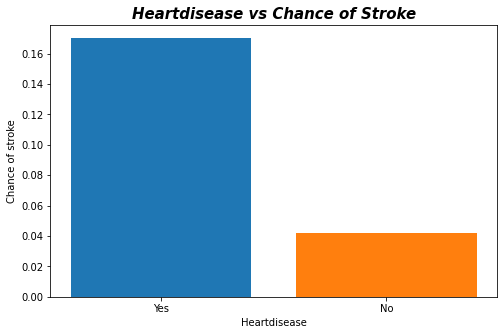

In [25]:
yesno = {
    1 : 'Yes',
    0 : 'No'
}
plot_chances('heart_disease',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_tick_labels = yesno,
x_label = 'Heartdisease',
y_label = 'Chance of stroke',
title = 'Heartdisease vs Chance of Stroke',
)

Clearly from plot the chance of stroke increases for people with heart disease. So, we hypothesise as follows:

Null hypothesis : H0 :- Stroke chance is greater than average for a person with heart disease

Alternate hypothesis : H1 :- Stroke chance remains average for person with heart disease

In [26]:
compute_normal_confidence_interval(1, 'heart_disease', 'stroke', df, 0.05, 1, 'gt')

Sample mean of stroke for value 1 in heart_disease column is 0.17 and lies within confidence interval (0.01,inf)


Since chance of stroke for those with heart disease is significantly great, we accept the null hypothesis

Hence, chance of stroke is high for people who had heart disease

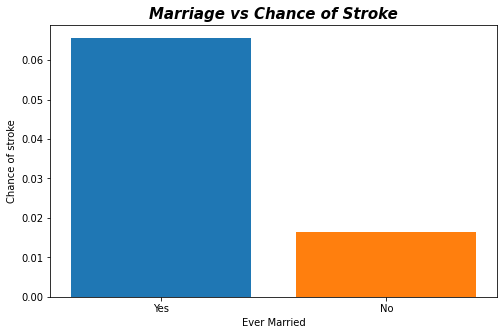

In [27]:
plot_chances('ever_married',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_label = 'Ever Married',
y_label = 'Chance of stroke',
title = 'Marriage vs Chance of Stroke',
)

Null hypothesis : H0 :- Stroke chance is above average for a person who has married once

Alternate hypothesis : H1 :- Stroke chance remains average for person who has married once

In [28]:
compute_normal_confidence_interval('Yes', 'ever_married', 'stroke', df, 0.05, 1, 'gt')

Sample mean of stroke for value Yes in ever_married column is 0.07 and lies within confidence interval (0.04,inf)


Since chance of stroke for those who married atleast once is significantly great, we accept the null hypothesis

Hence, chance of stroke is high for people who have married once. 
Also, the chance of stroke is significantly low for people who never married. The reason for the latter could be that the poplulation who have never married also includes children, whose chances of getting a stroke may be low.

For removing this ambiguity, let's plot such graphs for different age groups.


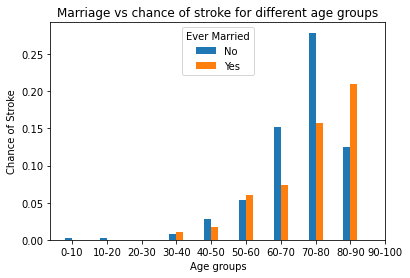

In [29]:
x_ticks = np.array([i for i in range(5, 105, 10)])
age = [(i, i+10) for i in range(0, 100, 10)]
plt.bar(x_ticks - 1, 
        [df[(df['age'] > age[i][0]) & (df['age'] < age[i][1]) & (df['ever_married'] == 'No')]['stroke'].mean() for i in range(10)],
        width=2, label = 'No')
plt.bar(x_ticks + 1,
        [df[(df['age'] > age[i][0]) & (df['age'] < age[i][1]) & (df['ever_married'] == 'Yes')]['stroke'].mean() for i in range(10)],
        width=2, label = 'Yes')

age_labels = [f'{age[i][0]}-{age[i][1]}' for i in range(len(age))]
plt.xticks(x_ticks, labels = age_labels)
plt.xlabel('Age groups')
plt.ylabel('Chance of Stroke')
plt.legend(title = 'Ever Married')
plt.title('Marriage vs chance of stroke for different age groups')

plt.show()

From plot it is clear that stroke chances are high for married people who are aged between 0-36 years, as compared to people from same age group who are not married. However, after 40 years, chances of stroke are high among those who have never married, exception being at 50-60 and 80-90.

Let's plot the category vs chance plot for work types

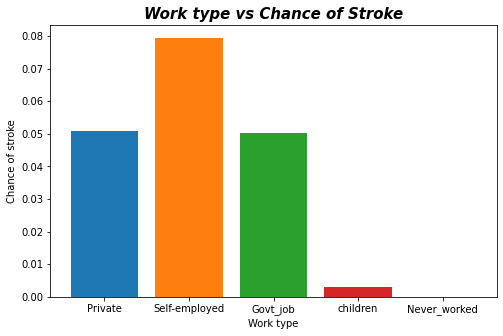

In [30]:
plot_chances('work_type',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_label = 'Work type',
y_label = 'Chance of stroke',
title = 'Work type vs Chance of Stroke',
)

We see from plot that the chance of stroke for people who are self-employed is higher than rest, and for people who have never worked(including children) it is quite low. So, we can hypothesise as follows:

Null hypothesis : H0 :- 

(i)Stroke chance is above average for a person who is self-employed

(ii)Stroke chance is average for a person with government job, or a person with private job.

(iii)Stroke chance is below average for a person who has never worked or is a child.

Let's test our hypothesis at level of significance 0.05

In [31]:
compute_normal_confidence_interval('Self-employed', 'work_type', 'stroke', df, 0.05, 1, 'gt')
compute_normal_confidence_interval('Private', 'work_type', 'stroke', df, 0.05)
compute_normal_confidence_interval('Govt_job', 'work_type', 'stroke', df, 0.05)
compute_normal_confidence_interval('children', 'work_type', 'stroke', df, 0.05, 1, 'lt')
compute_normal_confidence_interval('Never_worked', 'work_type', 'stroke', df, 0.05, 1, 'lt')

Sample mean of stroke for value Self-employed in work_type column is 0.08 and lies within confidence interval (0.03,inf)
Sample mean of stroke for value Private in work_type column is 0.05 and lies within confidence interval (0.04,0.06)
Sample mean of stroke for value Govt_job in work_type column is 0.05 and lies within confidence interval (0.03,0.07)
Sample mean of stroke for value children in work_type column is 0.00 and lies within confidence interval (-inf,0.05)
Sample mean of stroke for value Never_worked in work_type column is 0.00 and lies within confidence interval (-inf,0.05)


We see that our null hypothesis is true. Hence, we accept it.

Hence, we conclude that:
(i)chance of stroke is significantly high for people who are self-employed.

(ii)chance of stroke is average for people with government or private job.

(iii)chance of stroke is significantly low for people with no job/children.

Let's plot the chances of stroke for people residing in Rural and Urban Areas

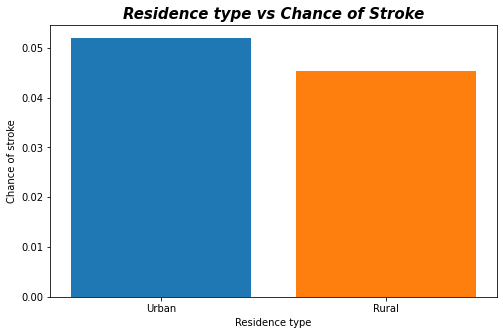

In [32]:
plot_chances('Residence_type',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_label = 'Residence type',
y_label = 'Chance of stroke',
title = 'Residence type vs Chance of Stroke',
)

Null hypothesis : H0 :- Stroke chance remains average for a person who is from Urban area

Alternate hypothesis : H1 :- Stroke chance is not average for person who is from Urban area

In [33]:
compute_normal_confidence_interval('Urban', 'Residence_type', 'stroke', df, 0.05)

Sample mean of stroke for value Urban in Residence_type column is 0.05 and lies within confidence interval (0.04,0.06)


Since chance of stroke for the person residing in urban area is within confidence interval, we accept the null hypothesis

Hence, chance of stroke is average for people from urban area

Let's plot the chances of stroke vs the smoking category of people

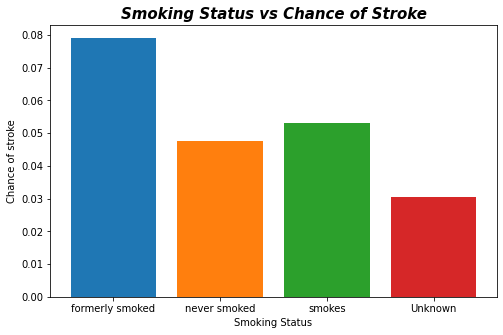

In [34]:
plot_chances('smoking_status',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
x_label = 'Smoking Status',
y_label = 'Chance of stroke',
title = 'Smoking Status vs Chance of Stroke',
)

From plot, we see that the chance of stroke for the people who have formerly smoked is high, followed by people who currently smoke, people who have never smoked, and people whose smoking status is not known.

So we can hypothesise that:

(i)Chance of stroke for the people who have formerly smoked is higher than average.

(ii)Chance of stroke for people who are currently smoking is average.

(iii)Chance of stroke for people who have never smoked is average.

(iv)Chance of stroke for people whose smoking status is not known is average.

Let's test these hypothesis at level of significance 0.05.

In [35]:
compute_normal_confidence_interval('formerly smoked', 'smoking_status', 'stroke', df, 0.05, 1, 'gt')
compute_normal_confidence_interval('smokes', 'smoking_status', 'stroke', df, 0.05)
compute_normal_confidence_interval('never smoked', 'smoking_status', 'stroke', df, 0.05)
compute_normal_confidence_interval('Unknown', 'smoking_status', 'stroke', df, 0.05)

Sample mean of stroke for value formerly smoked in smoking_status column is 0.08 and lies within confidence interval (0.03,inf)
Sample mean of stroke for value smokes in smoking_status column is 0.05 and lies within confidence interval (0.03,0.07)
Sample mean of stroke for value never smoked in smoking_status column is 0.05 and lies within confidence interval (0.04,0.06)
Sample mean of stroke for value Unknown in smoking_status column is 0.03 and lies outside of confidence interval (0.04,0.06)


We see that our hypothesis can be accepted based on confidence intervals.

Hence, we can conclude that for people:

(i) who have previously smoked but have discontinued the practice, the chance of stroke is significantly high

(ii) who never smoke, or are currently smoking, chance of stroke is average

(iii)whose smoking details are not known, chance of stroke is significantly low.

Last one poses a significant problem in making predictions. This is because stroke chance for this class significantly differs from average chance, and also because it represents large percentage(about 33%) of population, but provides no information.

Let's plot chances of stroke against age groups of people.

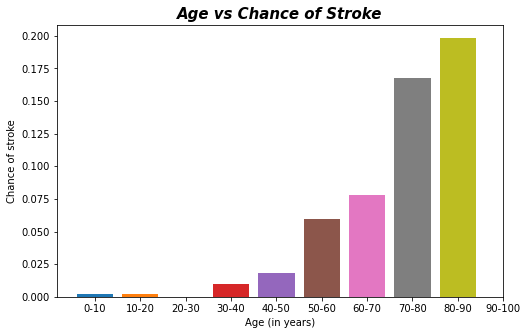

In [36]:
plot_chances('age',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
labels = (0, 100, 10),
x_label = 'Age (in years)',
y_label = 'Chance of stroke',
title = 'Age vs Chance of Stroke',
)

We see that the chance of stroke is high for the people with age > 50 and low for the age < 50.

Let's test these inferences at level of significance 0.05

In [37]:
compute_normal_confidence_interval((60, 90), 'age', 'stroke', df, 0.05, 1, 'gt')
compute_normal_confidence_interval((50, 60), 'age', 'stroke', df, 0.05)
compute_normal_confidence_interval((0, 50), 'age', 'stroke', df, 0.05, 1, 'lt')

Sample mean of stroke for range (60, 90) in age column is 0.14 and lies within confidence interval (0.03,inf)
Sample mean of stroke for range (50, 60) in age column is 0.06 and lies within confidence interval (0.03,0.07)
Sample mean of stroke for range (0, 50) in age column is 0.01 and lies within confidence interval (-inf,0.05)


Since the average chance of stroke lies in (0.04, 0.05), we see that: 

(i) chance of stroke is significantly high for those above 60 years in age.

(ii)chance of stroke is significantly low for those aged below 40 years

(iii)chance of stroke is average for those aged 50-60

Let's plot the chances of stroke against BMI.

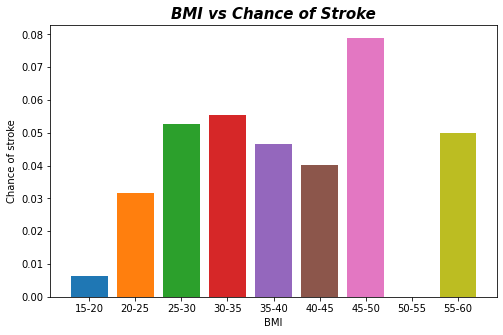

In [38]:
plot_chances('bmi',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
labels = (15, 60, 5),
x_label = 'BMI',
y_label = 'Chance of stroke',
title = 'BMI vs Chance of Stroke',
)

We see that for BMI 50-55, chances of stroke are nil. This could be due to less no. of data points with such BMI. Let's check if our assumption is true

In [39]:
print('No. of people with 50 < BMI < 55 :', df[(df['bmi'] > 50) & (df['bmi'] < 55)].shape[0])

No. of people with 50 < BMI < 55 : 44


44 is not a very small number to give such a large bias, if the dataset was obtained by proper sampling. Since we don't know the methodology behind collection of data, we cannot declare that there is significantly low chance of stroke associated with people with BMI between 50 and 55.

Now, we see that stroke chance peaks at 45-50 and is low at BMI 15-25. We will these for difference from mean, at level of significance 0.2

In [40]:
compute_normal_confidence_interval((45, 50), 'bmi', 'stroke', df, 0.2, 1, 'gt')
compute_normal_confidence_interval((15, 25), 'bmi', 'stroke', df, 0.2, 1, 'lt')

Sample mean of stroke for range (45, 50) in bmi column is 0.08 and lies within confidence interval (0.02,inf)
Sample mean of stroke for range (15, 25) in bmi column is 0.02 and lies within confidence interval (-inf,0.05)


Since the average chance of stroke lies in (0.04, 0.05), we see that: 

(i) chance of stroke is significantly high for those having bmi 45-50.

(ii)chance of stroke is significantly low for those whose bmi is below 25

(iii)minima at 50-55 is an anomaly

Let's plot chance of stroke against average glucose levels

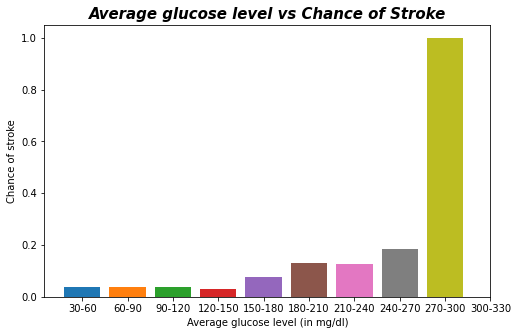

In [41]:
plot_chances('avg_glucose_level',
chance_column = 'stroke',
df = df,
figsize = (8, 5),
labels = (30, 330, 30),
x_label = 'Average glucose level (in mg/dl)',
y_label = 'Chance of stroke',
title = 'Average glucose level vs Chance of Stroke',
)

From plot, we see that chance of stroke is abnormally high(i.e., 100%) for those with mean glucose levels above 270 mg/dl.

This could be due to less no. of data points with such glucose levels. So let's take a count of people with such level of glucose

In [42]:
print('Count for some extreme cases: ')
print('People with glucose levels higher than 270mg/dl : ', df[df['avg_glucose_level'] > 270].shape[0])
print('People with glucose levels between 240-270 mg/dl : ', df[(df['avg_glucose_level'] < 270) & (df['avg_glucose_level'] > 240)].shape[0])
print('People with glucose levels between 30-60 mg/dl : ', df[(df['avg_glucose_level'] < 60) & (df['avg_glucose_level'] > 30)].shape[0])

Count for some extreme cases: 
People with glucose levels higher than 270mg/dl :  1
People with glucose levels between 240-270 mg/dl :  54
People with glucose levels between 30-60 mg/dl :  220


Since there is only one such person having glucose level > 270, the stroke chance for this glucose level gives us no information.

Now, let's plot the chances of stroke against the glucose levels, this time excluding the case with glucose level above 270 mg/dl.

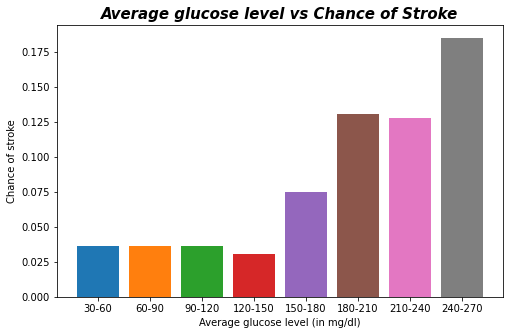

In [43]:
plot_chances('avg_glucose_level',
chance_column = 'stroke',
df = df[df['avg_glucose_level'] < 270],
figsize = (8, 5),
labels = (30, 270, 30),
x_label = 'Average glucose level (in mg/dl)',
y_label = 'Chance of stroke',
title = 'Average glucose level vs Chance of Stroke',
)

We see that chance of stroke is low for people with glucose levels upto 150 mg/dl. However, beyond that the chance of stroke increases.

Let's test whether the chance of stroke is significantly high for people with glucose levels greater than 150 mg/dl and significantly low for those with glucose levels below 150 mg/dl at level of significance 0.05

In [44]:
compute_normal_confidence_interval((0, 150), 'avg_glucose_level', 'stroke', df, 0.05, 1, 'lt')
compute_normal_confidence_interval((150, 300), 'avg_glucose_level', 'stroke', df, 0.05, 1, 'gt')

Sample mean of stroke for range (0, 150) in avg_glucose_level column is 0.04 and lies within confidence interval (-inf,0.06)
Sample mean of stroke for range (150, 300) in avg_glucose_level column is 0.12 and lies within confidence interval (0.03,inf)


Since the average chance of stroke lies in (0.04, 0.05), from plot it is clear that:

 (i) chance of stroke for people with glucose levels greater than 150 is significantly high,

(ii) chance of stroke for people with glucose levels lesser than 150 is significantly low.


## Conclusion

After thorough analysis we found that the main factors for the stroke are :-  hypertension, heart disease, age, and average glucose level. Other prominent factors were the type of job, and whether the person has married at least once. The risk was high for people with hypertension and heart disease. Also, it increases with age. However, for the children(those below 18 years of age), the risk was quite low. For people with diabetes, i.e., with those people whose average glucose levels were > 120, the risk of was high, and increased with increasing glucose levels. However, for those with low glucose levels(< 100 mg/dl), the risk was average.

The risk was high for people who are employed compared to those who are not. Among those who are employed the risk was high for people who are self-employed, while for those with private or government job, it was average.

Those who were married had overall higher risk compared to those who didn't marry. But for those aged above 40 years of age, the risk was generally higher among those who are not married.

Risk of stroke is average for both males and females. Hence gender is not a major factor in occurance of stroke. Same can be said about the residence type of person. People who live in urban areas and those who live in rural areas have average risk.

Most significant anomalies were from the BMI's relationship with risk of stroke. For people with low BMI, the risk was low, but for people with very high BMI, risk was much lower. 

However, we cannot draw any bold conclusions from this analysis. This is because we don't know the methodology used in collecting the data, and the source of data too. Nevertheless,  the data reinforces already known facts about stroke.
